# MIT-BIH Database exploration using wfdb library

In [2]:
import wfdb
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.fftpack
#%matplotlib inline

## 1. Example: display record for patient number 101

In [11]:
record_nb = '109'
sample_limit_down = 0
sample_limit_up = 650
 
record = wfdb.rdrecord('mitbih/' + record_nb, sampfrom=sample_limit_down, sampto=sample_limit_up)
annotation = wfdb.rdann('mitbih/' + record_nb, 'atr', sampfrom=sample_limit_down, sampto=sample_limit_up)

In [12]:
annotation.__dict__

{'ann_len': 4,
 'aux_note': ['(N\x00', '', '', ''],
 'chan': array([0, 0, 0, 0]),
 'contained_labels': None,
 'custom_labels': None,
 'description': None,
 'extension': 'atr',
 'fs': 360,
 'label_store': None,
 'num': array([0, 0, 0, 0]),
 'record_name': '109',
 'sample': array([ 18, 111, 343, 571]),
 'subtype': array([0, 0, 0, 0]),
 'symbol': ['+', 'L', 'L', 'L']}

In [13]:
record.__dict__

{'adc_gain': [200.0, 200.0],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [1024, 1024],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [25713, 22035],
 'comments': ['64 M 1508 694 x1',
  'Quinidine',
  'There is first degree AV block.  The PVCs are multiform.'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['109.dat', '109.dat'],
 'fmt': ['212', '212'],
 'fs': 360,
 'init_value': [1059, 1151],
 'n_sig': 2,
 'p_signal': array([[ 0.175,  0.635],
        [ 0.175,  0.635],
        [ 0.175,  0.635],
        ..., 
        [-0.95 , -0.015],
        [-0.915, -0.095],
        [-0.875, -0.175]]),
 'record_name': '109',
 'samps_per_frame': [1, 1],
 'sig_len': 650,
 'sig_name': ['MLII', 'V1'],
 'skew': [None, None],
 'units': ['mV', 'mV']}

In [14]:
record.p_signal[annotation.sample]

array([[ 0.085,  0.59 ],
       [ 0.535, -0.34 ],
       [ 0.365, -0.845],
       [ 0.555, -1.21 ]])

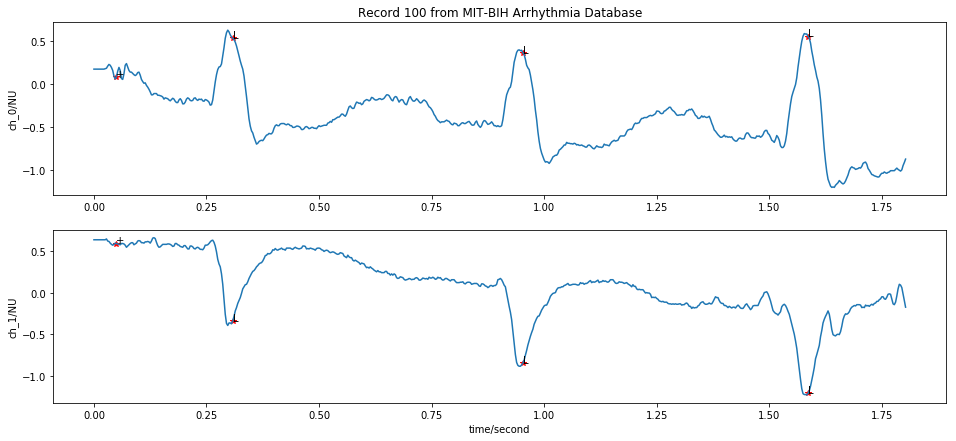

In [15]:
wfdb.plot_items(signal = record.p_signal, 
                ann_samp = [annotation.sample-sample_limit_down, annotation.sample-sample_limit_down],
                ann_sym = [annotation.symbol, annotation.symbol],
                title = 'Record 100 from MIT-BIH Arrhythmia Database',
                fs = record.fs,
                time_units = 'seconds',
                figsize = (16,7)
                )

## 2. Pre process signals

#### Smooth with Fourier Transform

_Note: This smoothing method still produces a very oscillating signal_

In [18]:
channel = 0

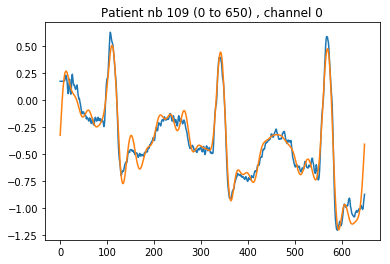

In [19]:
x = np.arange(record.sig_len)
y = record.p_signal[:, channel]

# find weights in fourier decomposition using FFT
w = sci.fftpack.rfft(y)
spectrum = w**2

# keep only terms of weight**2 > threshold 
cutoff_idx = spectrum < (spectrum.max()/800)
w2 = w.copy()
w2[cutoff_idx] = 0

# rebuild signal using inverse FFT 
y2 = sci.fftpack.irfft(w2)

plt.plot(y)
plt.plot(y2)
plt.title('Patient nb %s (%i to %i) , channel %i' 
          % (record_nb, sample_limit_down, sample_limit_up, channel))
plt.show()

#### Smooth with Moving average

_Note: apparently a slow method, might take a while to compute on the whole dataset_

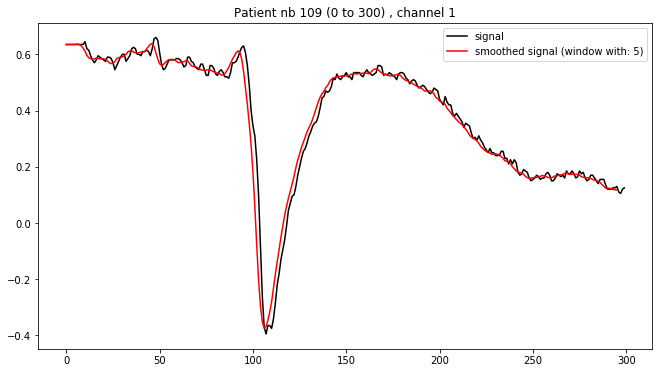

In [171]:
data = record.p_signal[:, channel]
window_width = 5

cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

plt.figure(figsize=(11,6))
plt.plot(data, '-k', label='signal')
plt.plot(ma_vec, '-r', label='smoothed signal (window with: %i)' % window_width)
plt.legend()
plt.title('Patient nb %s (%i to %i) , channel %i' 
          % (record_nb, sample_limit_down, sample_limit_up, channel))
plt.show()

#### Derivative

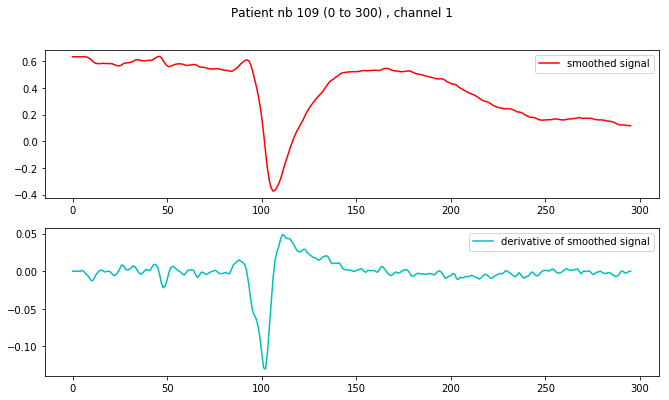

In [172]:
plt.figure(figsize=(11,6))
plt.subplot(211)
plt.plot(ma_vec, '-r', label='smoothed signal')
plt.legend()

plt.subplot(212)
plt.plot(np.gradient(ma_vec), '-c', label='derivative of smoothed signal')
plt.legend()
plt.suptitle('Patient nb %s (%i to %i) , channel %i' 
             % (record_nb, sample_limit_down, sample_limit_up, channel))
plt.show()

## 3. Database characteristics

#### Length of the signals 

In [29]:
patients_id = []

with open('mitbih/file_list.txt', 'r') as files:
    for f in files:
        record_nb = str(f[:3])
        patients_id.append(int(f[:3]))
        record = wfdb.rdrecord('mitbih/' + record_nb)
        sig_len = record.sig_len
        sig_duration = sig_len / record.fs
        print('Patient %s :' % record_nb)
        print('\t signal of length %i' % sig_len)
        print('\t signal duration %.1f seconds' % sig_duration)

Patient 100 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 101 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 102 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 103 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 104 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 105 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 106 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 107 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 108 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 109 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 111 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 112 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 113 :
	 signal of length 650000
	 signal duration 1805.6 seconds
Patient 114 :
	 signal of length 650000
	 signal du

#### List of patients id

In [30]:
print(patients_id)

[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]


## 4. Feature engineering, per patient

In [342]:
df_patient = pd.DataFrame(index=patients_id)

In [343]:
for pat in patients_id:
    record = wfdb.rdrecord('mitbih/' + str(pat))
    annotation = wfdb.rdann('mitbih/' + str(pat), 'atr')
    
    # just use channel 0
    channel = 0
    signal = record.p_signal[:, channel]
    
    # signal values where annotation is present
    sig_at_annot = signal[annotation.sample]
    dist_btw_annot = (annotation.sample[1:] - annotation.sample[:-1]) / record.fs
    
    df_patient.loc[pat, 'Max'] = np.max(signal)
    df_patient.loc[pat, 'Min'] = np.min(signal)
    df_patient.loc[pat, 'Mean'] = np.mean(signal)
    df_patient.loc[pat, 'Percent10_peak'] = np.percentile(sig_at_annot, 10)
    df_patient.loc[pat, 'Mean_peak'] = np.mean(sig_at_annot)
    df_patient.loc[pat, 'Percent90_peak'] = np.percentile(sig_at_annot, 90)
    df_patient.loc[pat, 'Mean_Peak2Peak'] = np.mean(dist_btw_annot)

In [344]:
df_patient = df_patient.round(2)
df_patient.head(10)

,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Mean_Peak2Peak
100,1.44,-2.72,-0.31,0.81,0.96,1.14,0.79
101,2.42,-3.18,-0.28,1.14,1.33,1.53,0.96
102,1.38,-1.66,-0.25,0.51,0.70,0.88,0.82
103,3.12,-2.61,-0.23,1.47,1.71,1.91,0.86
104,1.98,-1.94,-0.23,0.04,0.53,1.22,0.78
105,3.00,-3.72,-0.23,0.96,1.14,1.36,0.67
106,2.57,-2.06,-0.18,0.64,1.38,2.13,0.86
107,3.46,-3.32,-0.23,1.20,1.59,2.22,0.84
108,2.37,-3.04,-0.23,-0.91,-0.08,0.75,0.99
109,3.13,-3.20,-0.23,1.21,1.50,2.33,0.71


## 4. Pre processing : generate a database of 10sec windows

In [200]:
# size in seconds of the truncated windows
windows_size_seconds = 10

# list of all windows and their corresponding annotations
all_windows = []
all_annot = []

# read MITBIH database and generate all 10sec samples
with open('mitbih/file_list.txt', 'r') as files:
    for f in files:
        f_records = []
        f_annot = []
        record_nb = str(f[:3])
        record = wfdb.rdrecord('mitbih/' + record_nb)
        sig_len = record.sig_len
        annotation = wfdb.rdann('mitbih/' + record_nb, 'atr')
        windows_size = windows_size_seconds * record.fs
        #windows_nb = sig_len // windows_size
        for w in range(0, sig_len-windows_size, windows_size):
            f_records.append(wfdb.rdrecord('mitbih/' + record_nb, sampfrom=w, sampto=w+windows_size))
            temp_annot = wfdb.rdann('mitbih/' + record_nb, 'atr', sampfrom=w, sampto=w+windows_size)
            # move annot to 0: -1 because annotations started at 1 (python array start at 0)
            temp_annot.sample -= (w + 1)
            f_annot.append(temp_annot)
        all_windows.append(f_records)
        all_annot.append(f_annot)
        print(record_nb)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [201]:
# Number of generated samples
print('nb of patients:', len(all_windows))
print('nb of windows per patient:', len(all_windows[0]))

nb of patients: 48
nb of windows per patient: 180


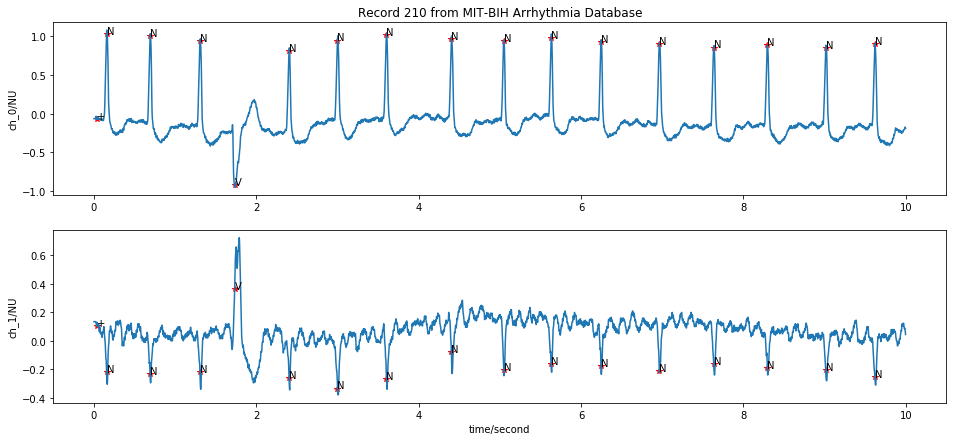

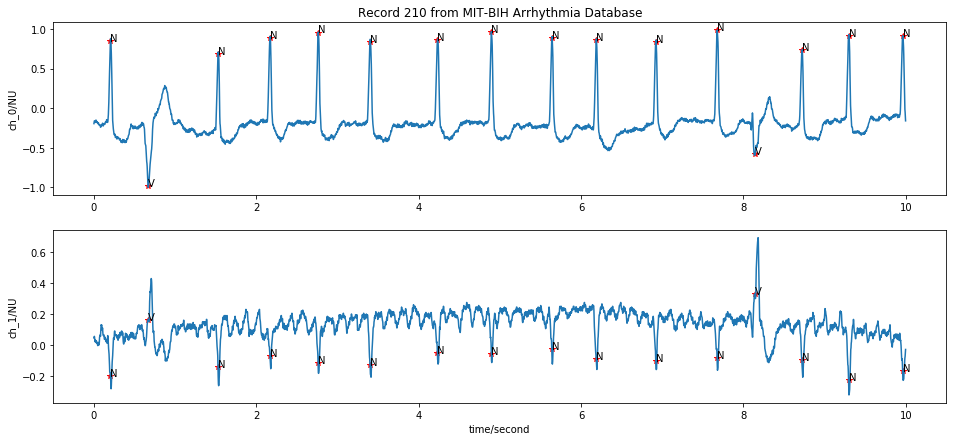

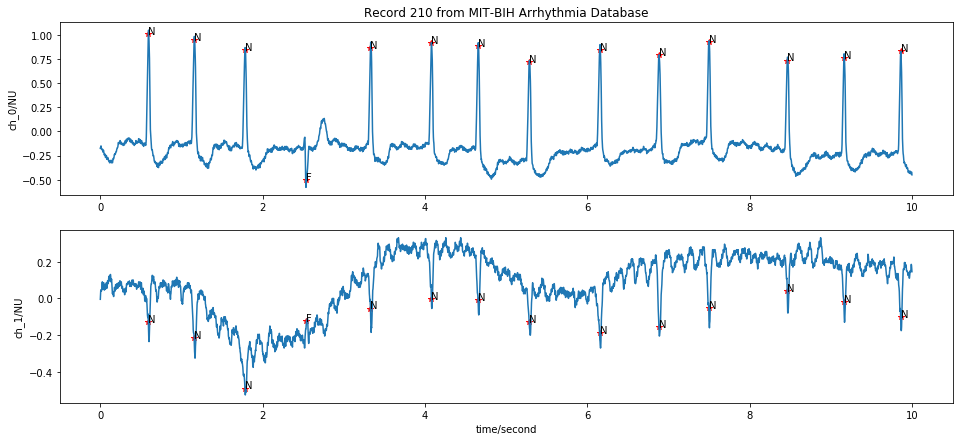

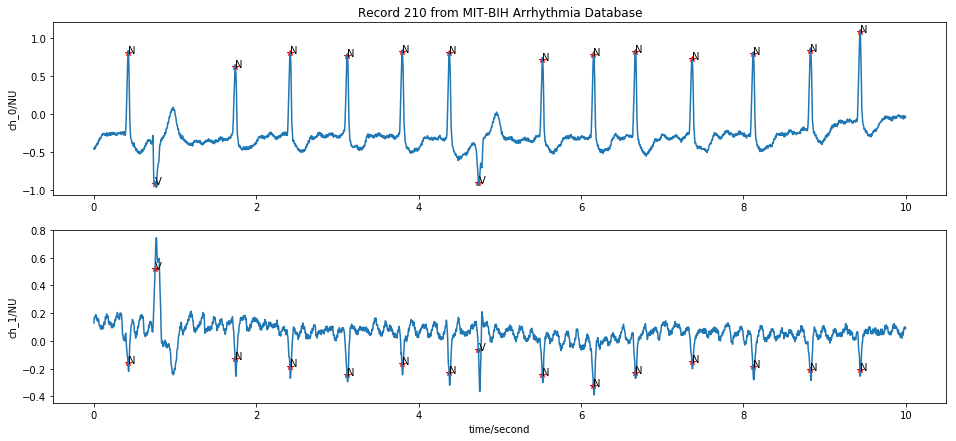

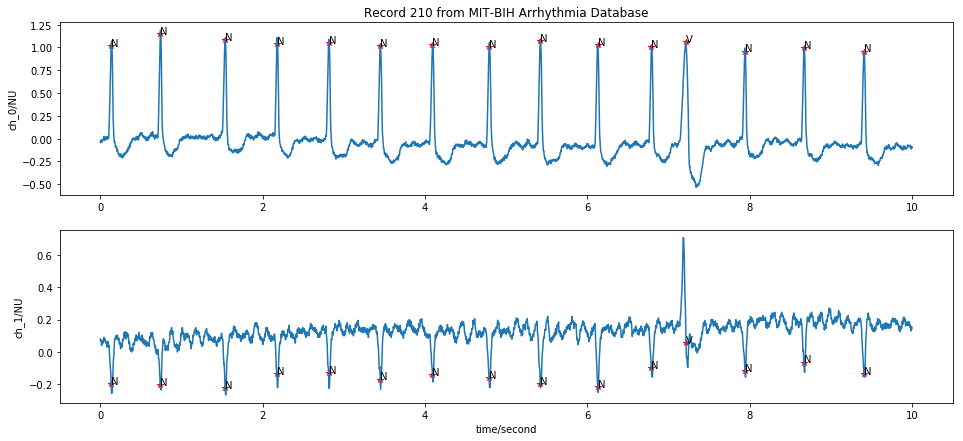

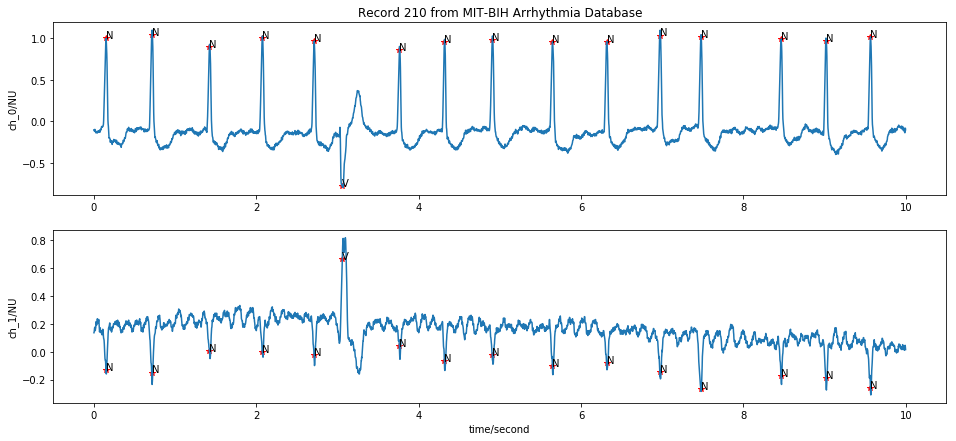

In [202]:
# choose a patient
patient = 31

# plot the first few windows for the chosen patient
for record, annotation in zip(all_windows[patient][:6], all_annot[patient][:6]):
    wfdb.plot_items(signal = record.p_signal, 
                ann_samp = [annotation.sample, annotation.sample],
                ann_sym = [annotation.symbol, annotation.symbol],
                title = 'Record %s from MIT-BIH Arrhythmia Database' % record.record_name,
                fs = record.fs,
                time_units = 'seconds',
                figsize = (16,7)
                )

In [338]:
df_windows = pd.DataFrame()

for pat in range(len(all_windows)):
    for w in range(len(all_windows[pat])):
        index = str(patients_id[pat]) + '_' + str(w)
        record = all_windows[pat][w]
        signal = record.p_signal
        annotation = all_annot[pat][w]
        sig_at_annot = signal[annotation.sample]
        dist_btw_annot = (annotation.sample[1:] - annotation.sample[:-1]) / record.fs
        
        df_windows.loc[index, 'Max'] = np.max(signal)
        df_windows.loc[index, 'Min'] = np.min(signal)
        df_windows.loc[index, 'Mean'] = np.mean(signal)
        df_windows.loc[index, 'Percent10_peak'] = np.percentile(sig_at_annot, 10)
        df_windows.loc[index, 'Mean_peak'] = np.mean(sig_at_annot)
        df_windows.loc[index, 'Percent90_peak'] = np.percentile(sig_at_annot, 90)
        df_windows.loc[index, 'Peak_height'] = np.mean(sig_at_annot) - df_windows.loc[index, 'Mean']
        df_windows.loc[index, 'Mean_Peak2Peak'] = np.mean(dist_btw_annot)
        # outliers for Peak2Peak if the distance btw a annotation and the next one
        # is significantly far from the mean (2 or 3 standard deviation)
        df_windows.loc[index, 'Outliers_Peak2Peak'] = max(dist_btw_annot > np.mean(dist_btw_annot) + 2*np.std(dist_btw_annot))       
        df_windows.loc[index, 'N'] = annotation.symbol.count('N')
        df_windows.loc[index, 'NotN'] = annotation.ann_len - annotation.symbol.count('N')
        df_windows.loc[index, 'V'] = annotation.symbol.count('V')
        df_windows.loc[index, 'Gender'] = record.comments[0][:2]
        df_windows.loc[index, 'Age'] = record.comments[0][3]

print("Done")

Done


In [345]:
#df_windows.sort_values(by=['V', 'Outliers_Peak2Peak'], ascending=True).head(20)
df_windows.head(20)

,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Peak_height,Mean_Peak2Peak,Outliers_Peak2Peak,N,NotN,V,Gender,Age
100_0,0.960,-0.645,-0.261548,0.3530,0.596786,0.8100,0.858334,0.756838,False,12.0,2.0,0.0,69,M
100_1,0.975,-0.585,-0.294517,0.4400,0.640625,0.8205,0.935142,0.819192,True,12.0,0.0,0.0,69,M
100_2,1.050,-0.680,-0.312948,0.3945,0.650833,0.8335,0.963781,0.808081,False,12.0,0.0,0.0,69,M
100_3,1.050,-0.695,-0.298066,0.4330,0.662708,0.8235,0.960774,0.817424,True,12.0,0.0,0.0,69,M
100_4,1.020,-0.640,-0.285185,0.3950,0.645000,0.8225,0.930185,0.815741,False,13.0,0.0,0.0,69,M
100_5,1.030,-0.650,-0.264953,0.4350,0.647917,0.8400,0.912870,0.807071,False,12.0,0.0,0.0,69,M
100_6,1.120,-0.590,-0.277709,0.3225,0.648654,0.9125,0.926363,0.802778,False,13.0,0.0,0.0,69,M
100_7,0.960,-0.655,-0.298796,0.3030,0.625833,0.8285,0.924629,0.818687,False,12.0,0.0,0.0,69,M
100_8,1.035,-0.670,-0.309272,0.3145,0.614792,0.8845,0.924064,0.810606,True,12.0,0.0,0.0,69,M
100_9,1.125,-0.650,-0.269829,0.3915,0.699583,0.8985,0.969413,0.809848,False,12.0,0.0,0.0,69,M


In [346]:
def plot_single_window(index):
    patient = int(str(index)[:3])
    window = int(str(index)[3:7])
    record = all_windows[patients_id.index(patient)][window]
    annotation = all_annot[patients_id.index(patient)][window]
    wfdb.plot_items(signal = record.p_signal, 
                ann_samp = [annotation.sample, annotation.sample],
                ann_sym = [annotation.symbol, annotation.symbol],
                title = 'Record %s from MIT-BIH Arrhythmia Database' % record.record_name,
                fs = record.fs,
                time_units = 'seconds',
                figsize = (16,7)
                )
    
def get_value(index, feature):
    patient = int(str(index)[:3])
    window = int(str(index)[3:7])
    record = all_windows[patients_id.index(patient)][window]
    annotation = all_annot[patients_id.index(patient)][window]
    return getattr(annotation, feature)

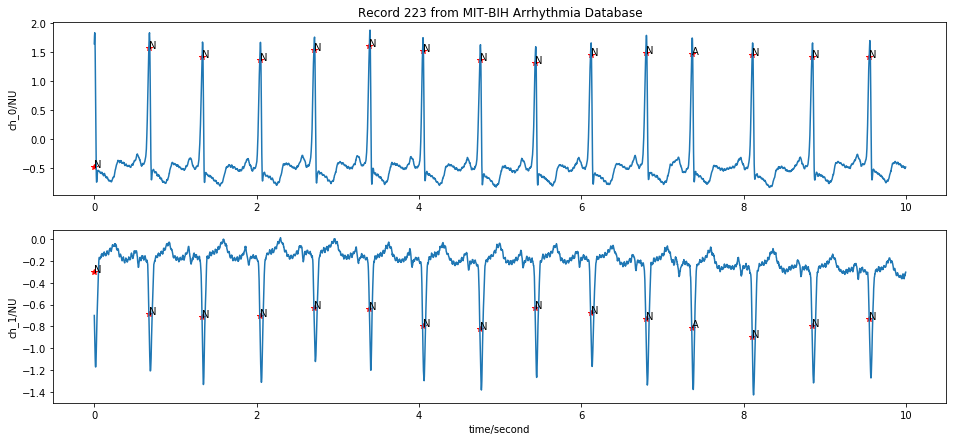

In [347]:
plot_single_window(223_87)

In [348]:
df_windows.describe()

,Max,Min,Mean,Percent10_peak,Mean_peak,Percent90_peak,Peak_height,Mean_Peak2Peak,N,NotN,V
count,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000,8640.000000
mean,1.573944,-1.544775,-0.226687,-0.581477,0.284369,1.162242,0.511055,0.805095,8.660069,4.341667,0.824074
std,0.644878,0.756005,0.264973,0.720648,0.465027,0.603230,0.462494,0.178527,5.650678,5.282344,1.788589
min,-0.305000,-5.120000,-1.387769,-4.067000,-1.978056,-1.099500,-1.322897,0.260736,0.000000,0.000000,0.000000
25%,1.120000,-2.040000,-0.393305,-1.005000,-0.013857,0.803375,0.223852,0.676469,2.000000,0.000000,0.000000
50%,1.575000,-1.410000,-0.095675,-0.525000,0.335354,1.166000,0.515122,0.796717,10.000000,1.000000,0.000000
75%,2.016250,-0.955000,-0.043833,-0.105000,0.607264,1.561625,0.822240,0.905833,13.000000,9.000000,1.000000
max,5.115000,-0.290000,0.243431,1.345000,1.628846,3.542000,1.858881,2.607407,23.000000,38.000000,19.000000
